In [3]:
import csv
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, metrics

In [4]:
def normalizare(dt):
    mean = np.mean(dt)
    std_dev = np.std(dt)
    normalized_data = (dt - mean) / std_dev
    return normalized_data

In [5]:
def citireDate(numeFisier, numeVariabilaOutput, numeVariabilaInput1, inputVariabName2 = None):
    data = []
    dataNames = []
    with open(numeFisier) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                dataNames = row
            else:
                data.append(row)
            line_count += 1

    indexOutput = dataNames.index(numeVariabilaOutput)
    outputs = [float(row[indexOutput]) for row in data]
    outputs = normalizare(outputs)

    indexInput1 = dataNames.index(numeVariabilaInput1)
    input1 = [float(row[indexInput1]) if row[indexInput1] != '' else None for row in data]
    mean_input1 = sum([val for val in input1 if val is not None]) / len([val for val in input1 if val is not None])
    for i in range(len(input1)):
        if input1[i] is None:
            input1[i] = mean_input1
    input1 = normalizare(input1)

    input2 = []

    if inputVariabName2 is not None:
        indexInput2 = dataNames.index(inputVariabName2)
        input2 = [float(row[indexInput2]) if row[indexInput2] != '' else None for row in data]
        mean_input2 = sum([val for val in input2 if val is not None]) / len([val for val in input2 if val is not None])
        for i in range(len(input2)):
            if input2[i] is None:
                input2[i] = mean_input2
        input2 = normalizare(input2)

    if not len(input2):
        return outputs, input1
    else:
        return outputs, input1, input2

Ploturi de date


In [21]:

def plotDataHistogram(x, variableName):
    n, bins, patches = plt.hist(x, 10, color='teal')
    plt.title('Histogram of ' + variableName)
    plt.show()


def plotData(x1, y1, x2=None, y2=None, x3=None, y3=None, title=None):
    plt.plot(x1, y1, 'o', color='teal', label='train data')
    if x2:
        plt.scatter(x2, y2, color='purple', label='learnt model')
    if x3:
        plt.plot(x3, y3, '^', color='darkorange', label='test data')
    plt.title(title)
    plt.legend()


Functie care imparte datele in 80% training si 20% testing 

In [7]:
def separate_date(inputs, outputs):
  np.random.seed(5)
  indexes = [i for i in range(len(inputs))]
  trainSample = np.random.choice(indexes, int(0.8 * len(inputs)), replace = False)
  validationSample = [i for i in indexes  if not i in trainSample]
  trainInputs = [inputs[i] for i in trainSample]
  trainOutputs = [outputs[i] for i in trainSample]
  validationInputs = [inputs[i] for i in validationSample]
  validationOutputs = [outputs[i] for i in validationSample]
  return trainInputs, trainOutputs, validationInputs, validationOutputs

def plot_model(trainInputs, trainOutputs, w0, w1):
    noOfPoints = 1000
    xref = []
    val = min(trainInputs)
    step = (max(trainInputs) - min(trainInputs)) / noOfPoints
    for i in range(1, noOfPoints):
        xref.append(val)
        val += step
    yref = [w0 + w1 * el for el in xref]
    
    plt.plot(trainInputs, trainOutputs, 'o', color='teal', label='train data')
    plt.plot(xref, yref, '-', color='purple', label='learnt model')
    plt.title("train data and model")
    plt.legend()
    plt.show()

In [8]:
def compute_error(validationOutputs, computedValidationOutputs):
  error = 0.0
  for t1, t2 in zip(computedValidationOutputs, validationOutputs):
      error += (t1 - t2) ** 2
  error = error / len(validationOutputs)
  print("prediction error (manual): ", error)

  error = metrics.mean_squared_error(validationOutputs, computedValidationOutputs)
  print("prediction error (tool): ", error)

Functie care foloseste Tool ul pentru Prima problema

In [5]:
from sklearn.linear_model import SGDRegressor

def make_prediction_with_sgd(filePath, inputVariable, outputVariable):
    outputs, inputs = citireDate(filePath, outputVariable, inputVariable)

    plotDataHistogram(inputs, inputVariable)
    plotDataHistogram(outputs, outputVariable)

    plotData(inputs, outputs, [], [], [], [], inputVariable + " vs. " + outputVariable)

    trainInputs, trainOutputs, validationInputs, validationOutputs = separate_date(inputs, outputs)
    plotData(trainInputs, trainOutputs, [], [], validationInputs, validationOutputs, "train and test data")

    X_train = np.array(trainInputs).reshape(-1, 1)
    y_train = np.array(trainOutputs)

    model = SGDRegressor(max_iter=1000, learning_rate='constant', eta0=0.01)
    model.fit(X_train, y_train)

    w1 = model.coef_[0]       
    w0 = model.intercept_[0]   

    plot_model(trainInputs, trainOutputs, w0, w1)


    X_val = np.array(validationInputs).reshape(-1, 1)
    computedValidationOutputs = model.predict(X_val)


    plt.plot(validationInputs, computedValidationOutputs, marker='o', color='pink', label='computed validation data')
    plt.plot(validationInputs, validationOutputs, marker='^', color='yellow', label='real validation data')
    plt.title('computed validation and real validation data')
    plt.xlabel(inputVariable)
    plt.ylabel(outputVariable)
    plt.legend()
    plt.show()

    compute_error(validationOutputs, computedValidationOutputs)


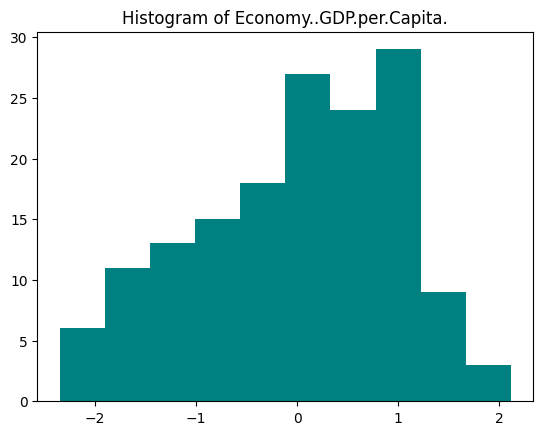

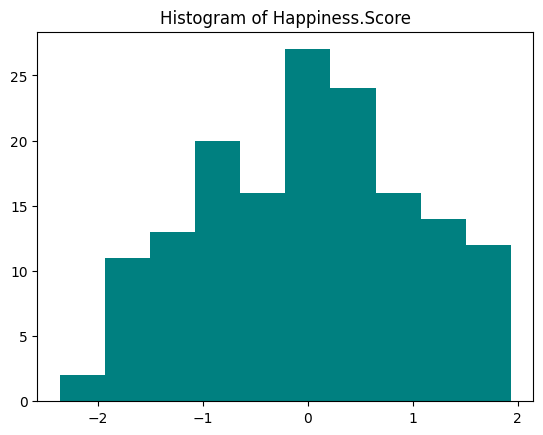

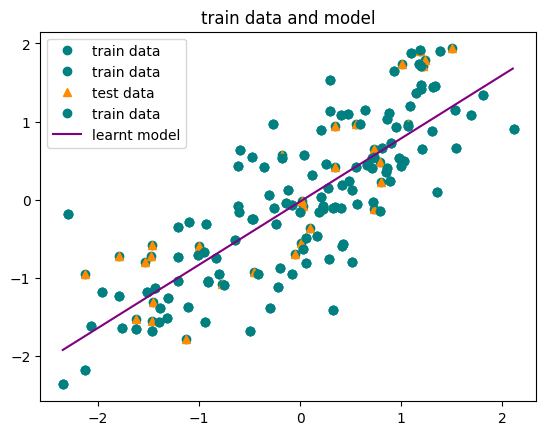

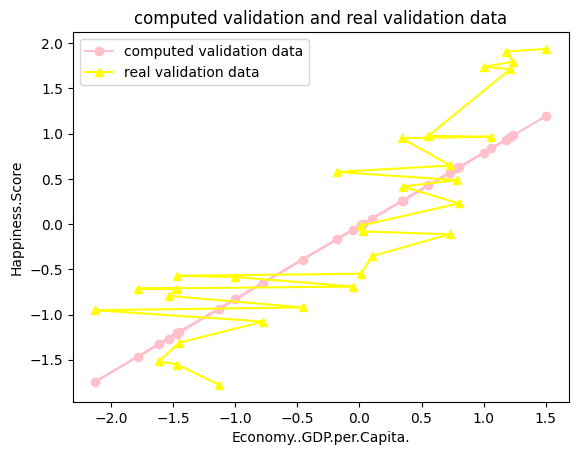

prediction error (manual):  0.3215919456462932
prediction error (tool):  0.3215919456462932


In [11]:
filePath = "2017_data.csv"
inputVariable = 'Economy..GDP.per.Capita.'
outputVariable = 'Happiness.Score'
make_prediction_with_sgd(filePath,inputVariable,outputVariable)

Gradientul descrescator scris de mine ( metoda cu batch-uri)

In [12]:

def batch_gradient_descent(x, y, learning_rate=0.01, epochs=1000):
   
    w = 0.0  
    b = 0.0
    n = len(x)
    
    x = np.array(x)
    y = np.array(y)

    for epoch in range(epochs):
        y_pred = w * x + b
        error = y_pred - y

        dw = (2 / n) * np.dot(x, error)
        db = (2 / n) * np.sum(error)

        w -= learning_rate * dw
        b -= learning_rate * db

        if epoch % 100 == 0:
            cost = np.mean((y - y_pred) ** 2)
            print(f"Epoch {epoch}: Cost={cost:.4f}, w={w:.4f}, b={b:.4f}")

    return b, w 

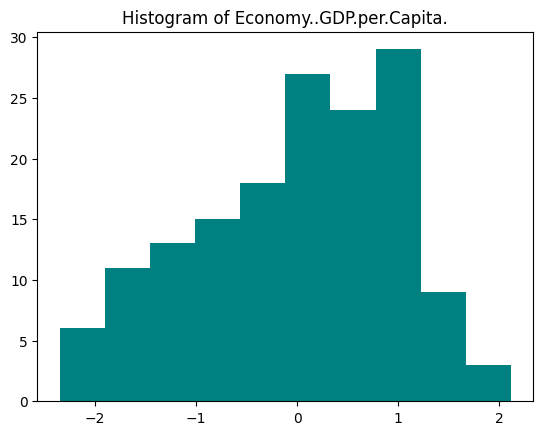

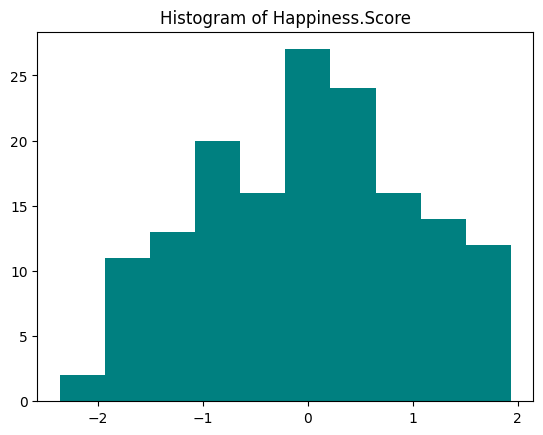

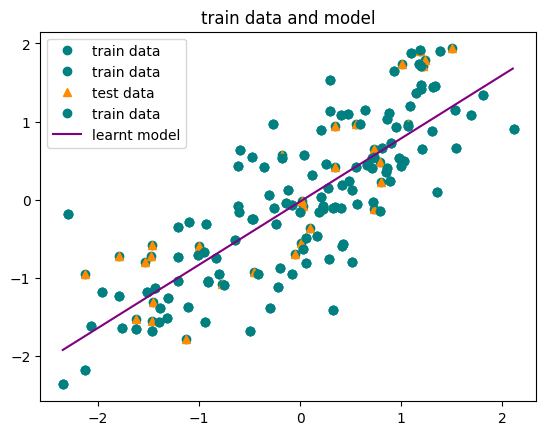

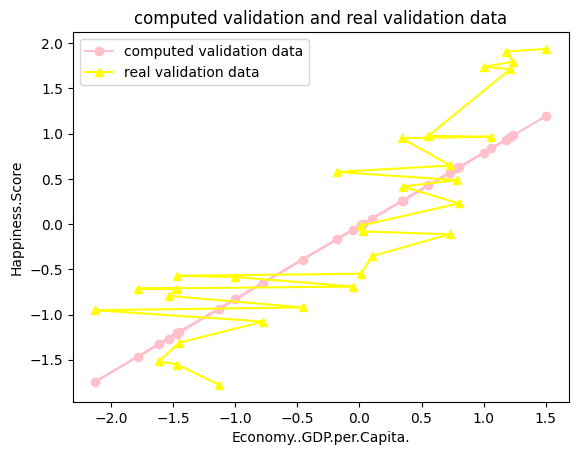

prediction error (manual):  0.3215919456462932
prediction error (tool):  0.3215919456462932


In [13]:
def make_prediction_batch(filePath, inputVariable, outputVariable):
    outputs, inputs = citireDate(filePath, outputVariable, inputVariable)

    plotDataHistogram(inputs, inputVariable)
    plotDataHistogram(outputs, outputVariable)

    plotData(inputs, outputs, [], [], [], [], inputVariable + " vs. " + outputVariable)

    trainInputs, trainOutputs, validationInputs, validationOutputs = separate_date(inputs, outputs)
    plotData(trainInputs, trainOutputs, [], [], validationInputs, validationOutputs, "train and test data")

    w0, w1 = batch_gradient_descent(trainInputs, trainOutputs, learning_rate=0.01, epochs=1000)

    plot_model(trainInputs, trainOutputs, w0, w1)

    computedValidationOutputs = [w0 + w1 * x for x in validationInputs]

    plt.plot(validationInputs, computedValidationOutputs, marker='o', color='pink', label='computed validation data')
    plt.plot(validationInputs, validationOutputs, marker='^', color='yellow', label='real validation data')
    plt.title('computed validation and real validation data')
    plt.xlabel(inputVariable)
    plt.ylabel(outputVariable)
    plt.legend()
    plt.show()

    compute_error(validationOutputs, computedValidationOutputs)
    
filePath = "2017_data.csv"
inputVariable = 'Economy..GDP.per.Capita.'
outputVariable = 'Happiness.Score'
make_prediction_with_sgd(filePath,inputVariable,outputVariable)

In [9]:
def batch_gradient_descent_two_features(x1, x2, y, learning_rate=0.01, epochs=1000):
    w1, w2 = 0.0, 0.0  
    b = 0.0           
    n = len(y)

    x1 = np.array(x1)
    x2 = np.array(x2)
    y = np.array(y)

    for epoch in range(epochs):
        y_pred = w1 * x1 + w2 * x2 + b
        error = y_pred - y

        dw1 = (2 / n) * np.dot(x1, error)
        dw2 = (2 / n) * np.dot(x2, error)
        db = (2 / n) * np.sum(error)

        w1 -= learning_rate * dw1
        w2 -= learning_rate * dw2
        b -= learning_rate * db

        if epoch % 100 == 0:
            cost = np.mean((y - y_pred) ** 2)
            print(f"Epoch {epoch}: Cost={cost:.4f}, w1={w1:.4f}, w2={w2:.4f}, b={b:.4f}")

    return b, w1, w2

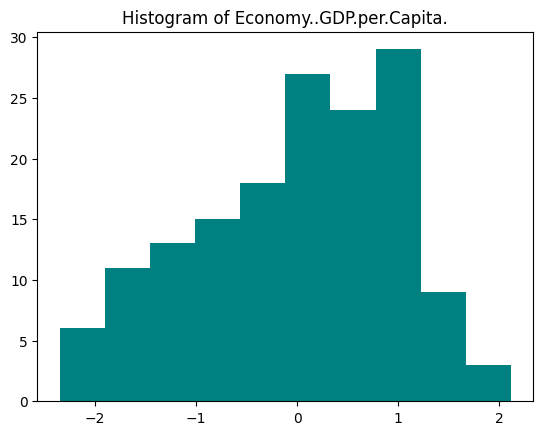

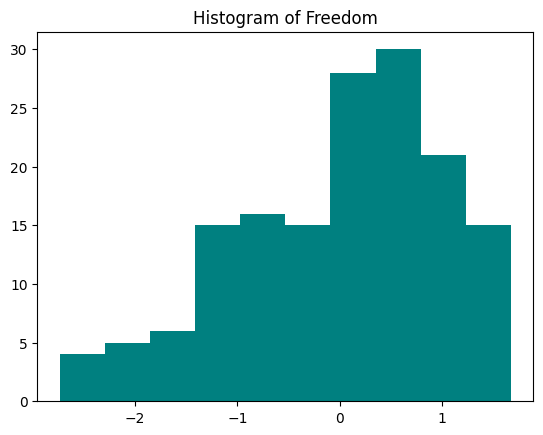

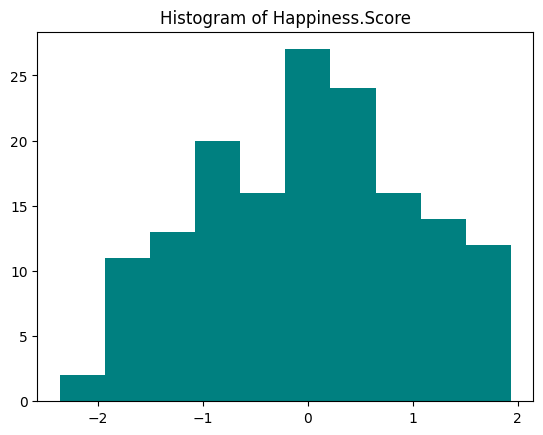

Epoch 0: Cost=0.9572, w1=0.0153, w2=0.0102, b=-0.0000
Epoch 100: Cost=0.2735, w1=0.6076, w2=0.3228, b=-0.0174
Epoch 200: Cost=0.2663, w1=0.6803, w2=0.3190, b=-0.0256
Epoch 300: Cost=0.2660, w1=0.6936, w2=0.3109, b=-0.0276
Epoch 400: Cost=0.2660, w1=0.6968, w2=0.3081, b=-0.0280
Epoch 500: Cost=0.2660, w1=0.6976, w2=0.3073, b=-0.0281
Epoch 600: Cost=0.2660, w1=0.6979, w2=0.3070, b=-0.0281
Epoch 700: Cost=0.2660, w1=0.6979, w2=0.3070, b=-0.0282
Epoch 800: Cost=0.2660, w1=0.6979, w2=0.3069, b=-0.0282
Epoch 900: Cost=0.2660, w1=0.6980, w2=0.3069, b=-0.0282


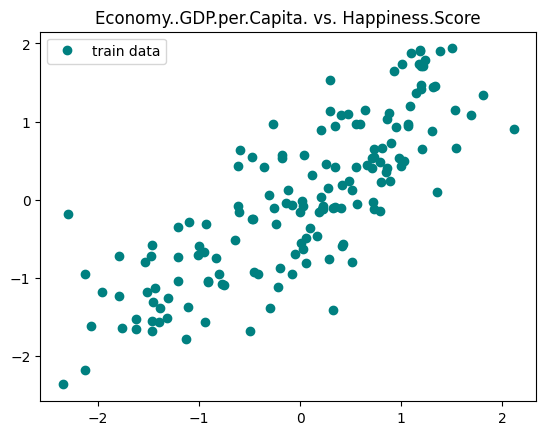

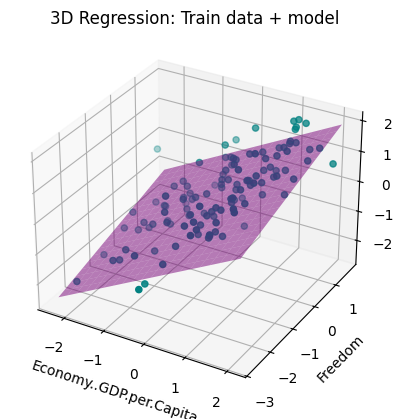

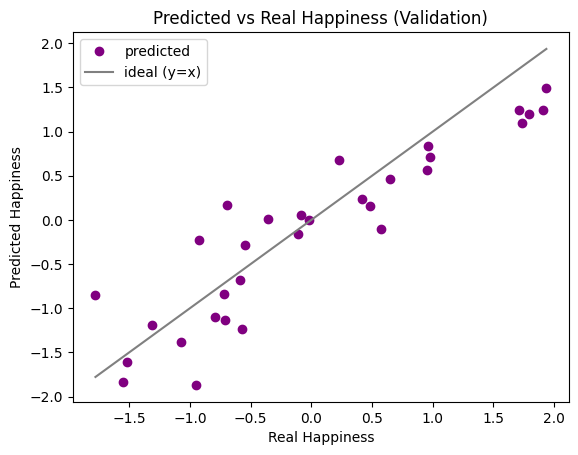

prediction error (manual):  0.21851590220022074
prediction error (tool):  0.21851590220022074


In [11]:
from mpl_toolkits.mplot3d import Axes3D  

def make_prediction_two_inputs(filePath, inputVariable1, inputVariable2, outputVariable):
    outputs, input1, input2 = citireDate(filePath, outputVariable, inputVariable1, inputVariable2)


    plotDataHistogram(input1, inputVariable1)
    plotDataHistogram(input2, inputVariable2)
    plotDataHistogram(outputs, outputVariable)

    plotData(input1, outputs, [], [], [], [], inputVariable1 + " vs. " + outputVariable)

    trainX1, trainY, valX1, valY = separate_date(input1, outputs)
    trainX2, _, valX2, _ = separate_date(input2, outputs)

    w0, w1, w2 = batch_gradient_descent_two_features(trainX1, trainX2, trainY)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    trainX1_np = np.array(trainX1)
    trainX2_np = np.array(trainX2)
    trainY_np = np.array(trainY)

    ax.scatter(trainX1_np, trainX2_np, trainY_np, color='teal', label='Real data')

    x1_range = np.linspace(min(trainX1_np), max(trainX1_np), 20)
    x2_range = np.linspace(min(trainX2_np), max(trainX2_np), 20)
    x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
    y_pred_grid = w0 + w1 * x1_grid + w2 * x2_grid

    ax.plot_surface(x1_grid, x2_grid, y_pred_grid, alpha=0.5, color='purple')

    ax.set_xlabel(inputVariable1)
    ax.set_ylabel(inputVariable2)
    ax.set_zlabel(outputVariable)
    ax.set_title("3D Regression: Train data + model")
    plt.show()

    computed_val_outputs = [w0 + w1 * x1 + w2 * x2 for x1, x2 in zip(valX1, valX2)]

    plt.plot(valY, computed_val_outputs, 'o', color='purple', label='predicted')
    plt.plot(valY, valY, '-', color='gray', label='ideal (y=x)')
    plt.title('Predicted vs Real Happiness (Validation)')
    plt.xlabel('Real Happiness')
    plt.ylabel('Predicted Happiness')
    plt.legend()
    plt.show()

    compute_error(valY, computed_val_outputs)
    
filePath = "2017_data.csv"
inputVariable = 'Economy..GDP.per.Capita.'
input_var2='Freedom'
outputVariable = 'Happiness.Score'
make_prediction_two_inputs(filePath,inputVariable,input_var2,outputVariable)

<H1> Problema 2:Clasificarea Tesuturilor Cancerigene </H1> 

In [18]:

from turtle import pd
def citireDate_cancer(filePath):
    with open(filePath, 'r') as f:
        reader = csv.reader(f)
        data = list(reader)
    inputs = []
    outputs = []

    for row in data:
        try:
            radius = float(row[2])
            texture = float(row[3])
            label = 1 if row[1] == 'M' else 0  # M = malign, B = benign

            inputs.append([radius, texture])
            outputs.append(label)
        except:
            continue  

    return np.array(inputs), np.array(outputs)

def normalize_features(X):
    return (X - X.mean(axis=0)) / X.std(axis=0)

In [25]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict_prob(X, weights):
    return sigmoid(np.dot(X, weights))

def compute_cost(X, y, weights):
    m = len(y)
    predictions = predict_prob(X, weights)
    cost = - (1/m) * np.sum(y * np.log(predictions + 1e-15) + (1 - y) * np.log(1 - predictions + 1e-15))
    return cost

def gradient_descent_logistic(X, y, learning_rate=0.01, epochs=1000, loss='log'):
    m, n = X.shape
    weights = np.zeros(n)

    for epoch in range(epochs):
        predictions = predict_prob(X, weights)
        errors = predictions - y
        gradient = (1/m) * np.dot(X.T, errors)
        weights -= learning_rate * gradient

        if epoch % 100 == 0:
            if loss == 'mse':
                cost = np.mean((predictions - y) ** 2)
            else:
                cost = compute_cost(X, y, weights)
            print(f"Epoch {epoch}: Cost={cost:.4f}")

    return weights


In [15]:
def evaluate_classifier(X, y, weights):
    probs = predict_prob(X, weights)
    predictions = (probs >= 0.5).astype(int)
    accuracy = np.mean(predictions == y)
    print(f"\n Acuratețea pe setul complet: {accuracy * 100:.2f}%")
    return accuracy

<h3> FARA TOOL </h3>

Epoch 0: Cost=0.6744
Epoch 100: Cost=0.2924
Epoch 200: Cost=0.2519
Epoch 300: Cost=0.2364
Epoch 400: Cost=0.2284
Epoch 500: Cost=0.2236
Epoch 600: Cost=0.2204
Epoch 700: Cost=0.2183
Epoch 800: Cost=0.2168
Epoch 900: Cost=0.2157

Leziune nouă cu raza = 18, textura = 10
Probabilitate malignitate: 0.7586
Predicție: Malignă

 Acuratețea pe setul complet: 79.82%


(1, np.float64(0.7586034013637467))

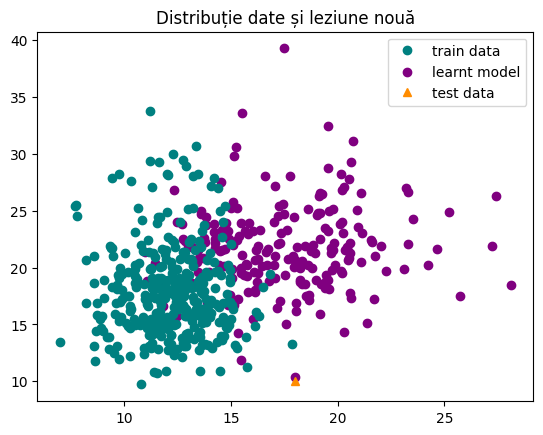

In [22]:
def train_and_classify_cancer_sample(filepath, test_radius, test_texture):
    X_raw, y = citireDate_cancer(filepath)
    mean = X_raw.mean(axis=0)
    std = X_raw.std(axis=0)
    X_norm = (X_raw - mean) / std

    inputs = X_norm.tolist()
    outputs = y.tolist()
    trainInputs, trainOutputs, valInputs, valOutputs = separate_date(inputs, outputs)

    trainX = np.c_[np.ones(len(trainInputs)), trainInputs]
    valX = np.c_[np.ones(len(valInputs)), valInputs]
    trainY = np.array(trainOutputs)
    valY = np.array(valOutputs)

    weights = gradient_descent_logistic(trainX, trainY, learning_rate=0.1, epochs=1000)

    new_point = np.array([[test_radius, test_texture]])
    new_point_norm = (new_point - mean) / std
    new_point_with_bias = np.c_[np.ones(1), new_point_norm]
    prob = predict_prob(new_point_with_bias, weights)
    label = 1 if prob >= 0.5 else 0

    print(f"\nLeziune nouă cu raza = {test_radius}, textura = {test_texture}")
    print(f"Probabilitate malignitate: {prob[0]:.4f}")
    print("Predicție:", "Malignă" if label == 1 else "Benignă")

    x1 = X_raw[y == 0][:, 0].tolist()
    y1 = X_raw[y == 0][:, 1].tolist()
    x2 = X_raw[y == 1][:, 0].tolist()
    y2 = X_raw[y == 1][:, 1].tolist()
    x3 = [test_radius]
    y3 = [test_texture]

    plotData(x1, y1, x2, y2, x3, y3, title="Distribuție date și leziune nouă")

    val_probs = predict_prob(valX, weights)
    val_preds = (val_probs >= 0.5).astype(int)

    evaluate_classifier(valX, valY, weights)

    return label, prob[0]

filepath_cancer = "wdbc.data"
train_and_classify_cancer_sample(filepath_cancer, test_radius=18, test_texture=10)

<h3> cu tool </h3> 

Epoch 0: Cost=0.6744
Epoch 100: Cost=0.2924
Epoch 200: Cost=0.2519
Epoch 300: Cost=0.2364
Epoch 400: Cost=0.2284
Epoch 500: Cost=0.2236
Epoch 600: Cost=0.2204
Epoch 700: Cost=0.2183
Epoch 800: Cost=0.2168
Epoch 900: Cost=0.2157

Leziune nouă cu raza = 18, textura = 10
Probabilitate malignitate: 0.7586
Predicție: Malignă

 Acuratețea pe setul complet: 79.82%


(1, np.float64(0.7586034013637467))

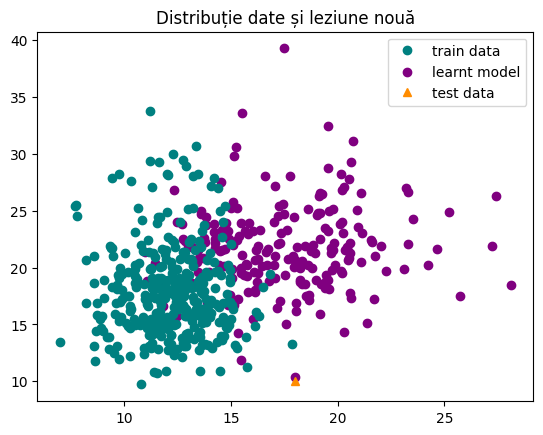

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def train_and_classify_cancer_sample_tool(filepath, test_radius, test_texture):
    X_raw, y = citireDate_cancer(filepath)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_raw)

    trainX, valX, trainY, valY = train_test_split(X_scaled, y, test_size=0.2, random_state=5)

    model = LogisticRegression()
    model.fit(trainX, trainY)

    new_point = np.array([[test_radius, test_texture]])
    new_point_scaled = scaler.transform(new_point)
    prob = model.predict_proba(new_point_scaled)[0][1]
    label = model.predict(new_point_scaled)[0]

    print(f"\nLeziune nouă cu raza = {test_radius}, textura = {test_texture}")
    print(f"Probabilitate malignitate: {prob:.4f}")
    print("Predicție:", "Malignă" if label == 1 else "Benignă")

    val_preds = model.predict(valX)

    weights = np.concatenate(([model.intercept_[0]], model.coef_[0]))
    valX_bias = np.c_[np.ones(len(valX)), valX]

    evaluate_classifier(valX_bias, valY, weights)

filepath_cancer = "wdbc.data"
train_and_classify_cancer_sample(filepath_cancer, test_radius=18, test_texture=10)

<h3> Validare incrucisata si investigarea diferitelor funcții de loss </h3> 

In [26]:
def cross_validate_logistic_manual(X, y, k=5, learning_rate=0.1, epochs=1000, loss='log'):
    n = len(X)
    indices = np.arange(n)
    np.random.seed(42)
    np.random.shuffle(indices)

    fold_size = n // k
    scores = []

    for i in range(k):
        val_indices = indices[i*fold_size:(i+1)*fold_size] if i < k-1 else indices[i*fold_size:]
        train_indices = np.setdiff1d(indices, val_indices)

        trainX = X[train_indices]
        valX = X[val_indices]
        trainY = y[train_indices]
        valY = y[val_indices]

        trainX_bias = np.c_[np.ones(len(trainX)), trainX]
        valX_bias = np.c_[np.ones(len(valX)), valX]

        weights = gradient_descent_logistic(trainX_bias, trainY, learning_rate=learning_rate, epochs=epochs, loss=loss)
        acc = evaluate_classifier(valX_bias, valY, weights)
        scores.append(acc)

    print(f"\nAcuratețea medie ({k}-fold, loss={loss}): {np.mean(scores) * 100:.2f}%")

Epoch 0: Cost=0.6744
Epoch 100: Cost=0.2924
Epoch 200: Cost=0.2519
Epoch 300: Cost=0.2364
Epoch 400: Cost=0.2284
Epoch 500: Cost=0.2236
Epoch 600: Cost=0.2204
Epoch 700: Cost=0.2183
Epoch 800: Cost=0.2168
Epoch 900: Cost=0.2157

Leziune nouă cu raza = 18, textura = 10
Probabilitate malignitate: 0.7586
Predicție: Malignă

 Acuratețea pe setul complet: 79.82%


(1, np.float64(0.7586034013637467))

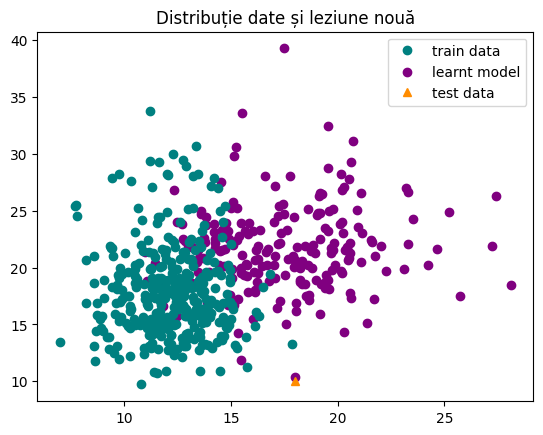

In [28]:
def train_with_cross_validation(filepath, k=5, learning_rate=0.1, epochs=1000):
    X, y = citireDate_cancer(filepath)
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    cross_validate_logistic_manual(X, y, k=k, learning_rate=learning_rate, epochs=epochs, loss='log')
    
filepath_cancer = "wdbc.data"
train_and_classify_cancer_sample(filepath_cancer, test_radius=18, test_texture=10)

<h1> Problema 3: ce fel de flori preferi? (trandafiri) </h1> 

In [30]:
def citireDate_iris(filepath):
    import csv

    inputs = []
    outputs = []

    with open(filepath, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            if len(row) != 5:
                continue  

            try:
                features = list(map(float, row[:4]))
                label = row[4]

                inputs.append(features)
                outputs.append(label)
            except:
                continue

    return np.array(inputs), np.array(outputs)

Fara Tool (functiile de mai sus) 

In [32]:
def train_and_classify_iris_flower(filepath, sample_features):
    X, y_raw = citireDate_iris(filepath)

    label_map = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
    y = np.array([label_map[label] for label in y_raw])

    mean = X.mean(axis=0)
    std = X.std(axis=0)
    X_norm = (X - mean) / std

    inputs = X_norm.tolist()
    outputs = y.tolist()
    trainInputs, trainOutputs, valInputs, valOutputs = separate_date(inputs, outputs)

    trainX = np.c_[np.ones(len(trainInputs)), trainInputs]
    valX = np.c_[np.ones(len(valInputs)), valInputs]
    trainY = np.array(trainOutputs)
    valY = np.array(valOutputs)

    num_classes = 3
    classifiers = []

    for c in range(num_classes):
        binary_trainY = (trainY == c).astype(int)
        weights = gradient_descent_logistic(trainX, binary_trainY, learning_rate=0.1, epochs=1000)
        classifiers.append(weights)

    sample = np.array([sample_features])
    sample_norm = (sample - mean) / std
    sample_with_bias = np.c_[np.ones(1), sample_norm]

    probs = [predict_prob(sample_with_bias, weights)[0] for weights in classifiers]
    predicted_class = np.argmax(probs)

    reverse_map = {v: k for k, v in label_map.items()}
    print("\nFloare testată:")
    print(f"Sepală: {sample_features[0]} x {sample_features[1]} cm")
    print(f"Petală: {sample_features[2]} x {sample_features[3]} cm")
    print(f"Specia prezisă:  {reverse_map[predicted_class]} (cu probabilitate {probs[predicted_class]:.4f})")

sample = [5.35, 3.85, 1.25, 0.4]
filepath_iris = "iris.data"
train_and_classify_iris_flower(filepath_iris, sample)

Epoch 0: Cost=0.6389
Epoch 100: Cost=0.0791
Epoch 200: Cost=0.0446
Epoch 300: Cost=0.0314
Epoch 400: Cost=0.0244
Epoch 500: Cost=0.0200
Epoch 600: Cost=0.0170
Epoch 700: Cost=0.0148
Epoch 800: Cost=0.0132
Epoch 900: Cost=0.0118
Epoch 0: Cost=0.6832
Epoch 100: Cost=0.5042
Epoch 200: Cost=0.4909
Epoch 300: Cost=0.4876
Epoch 400: Cost=0.4862
Epoch 500: Cost=0.4853
Epoch 600: Cost=0.4846
Epoch 700: Cost=0.4840
Epoch 800: Cost=0.4835
Epoch 900: Cost=0.4830
Epoch 0: Cost=0.6589
Epoch 100: Cost=0.2672
Epoch 200: Cost=0.2254
Epoch 300: Cost=0.2033
Epoch 400: Cost=0.1877
Epoch 500: Cost=0.1755
Epoch 600: Cost=0.1655
Epoch 700: Cost=0.1571
Epoch 800: Cost=0.1499
Epoch 900: Cost=0.1437

Floare testată:
Sepală: 5.35 x 3.85 cm
Petală: 1.25 x 0.4 cm
Specia prezisă:  Iris-setosa (cu probabilitate 0.9990)
